In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import lightgbm as lgb


In [13]:
# 1) Load datasets
df_nopaste = pd.read_excel('E27-40-10W-NOPASTE.xlsx')
df_paste   = pd.read_excel('E27-40-10W-PASTE.xlsx')
# Convert TIME to seconds
for df in (df_nopaste, df_paste):
    df['Elapsed'] = df['TIME'].apply(
        lambda t: t.hour*3600 + t.minute*60 + t.second + t.microsecond/1e6
    )
    df.set_index('Elapsed', inplace=True)

In [16]:
# 2) Forward-fill to length L=10262 at 30s intervals
L = 10262
time_index = np.arange(0, L*30, 30)  # seconds
df_nopaste_full = df_nopaste.reindex(time_index).ffill()
df_paste_full   = df_paste.reindex(time_index).ffill()


In [21]:
# 3) Smooth real windows
import numpy as np
from scipy.signal import savgol_filter

# identify your numeric measurement columns
numeric_cols = df_nopaste_full.select_dtypes(include=[np.number]).columns

# smooth up to the last real measurement timestamp
mask_nopaste = df_nopaste_full.index <= df_nopaste.index.max()

df_nopaste_full.loc[mask_nopaste, numeric_cols] = savgol_filter(
    df_nopaste_full.loc[mask_nopaste, numeric_cols].values, # type: ignore
    window_length=3,
    polyorder=2,
    axis=0
)

# likewise for the "paste" DataFrame
numeric_cols = df_paste_full.select_dtypes(include=[np.number]).columns
mask_paste = df_paste_full.index <= df_paste.index.max()

df_paste_full.loc[mask_paste, numeric_cols] = savgol_filter(
    df_paste_full.loc[mask_paste, numeric_cols].values, # type: ignore
    window_length=5,
    polyorder=2,
    axis=0
)


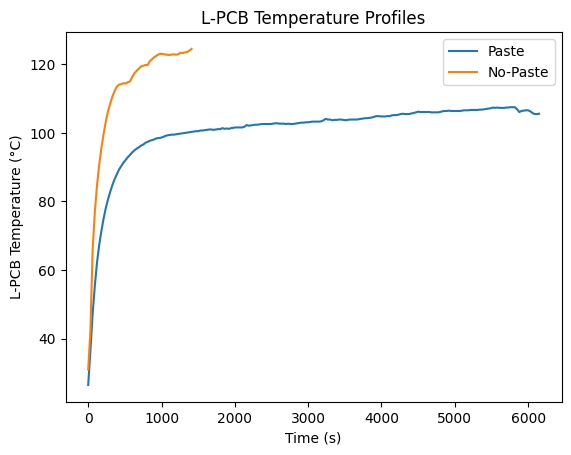

In [22]:
# 4) Plot L-PCB profiles
plt.figure()
plt.plot(df_paste['L-PCB'], label='Paste')
plt.plot(df_nopaste['L-PCB'], label='No-Paste')
plt.xlabel('Time (s)')
plt.ylabel('L-PCB Temperature (°C)')
plt.title('L-PCB Temperature Profiles')
plt.legend()
plt.savefig('pcb_profile.png')

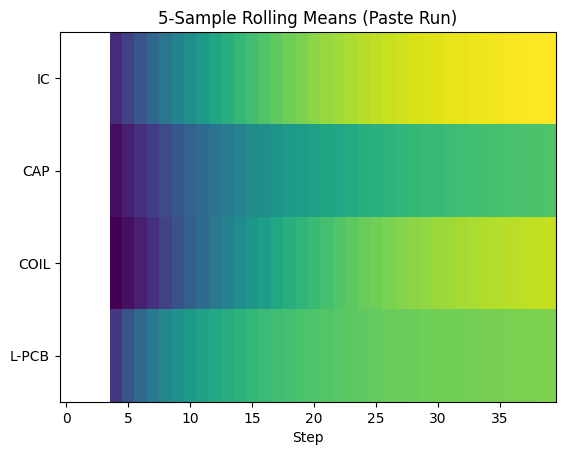

In [ ]:
# 5) Rolling mean heatmap for first 40 steps of paste
rolling_mean = df_paste_full[['IC','CAP','COIL','L-PCB']].rolling(5).mean().iloc[:40]
plt.figure()
plt.imshow(rolling_mean.T, aspect='auto')
plt.xlabel('Step')
plt.yticks(range(4), rolling_mean.columns) # type: ignore
plt.title('5-Sample Rolling Means (Paste Run)')
plt.savefig('rolling_mean_heatmap.png')

In [26]:
# 6) Feature extraction function
import numpy as np
import pandas as pd

def extract_features(df):
    # 1) sadece sayısal sütunlar
    numeric = df.select_dtypes(include=[np.number])

    # 2) rolling window
    roll = numeric.rolling(window=5, min_periods=1)

    feats = pd.concat([
        # orijinal ölçümler
        numeric,

        # rolling mean / var / skew
        roll.mean().add_suffix('_rm'),
        roll.var().add_suffix('_rv'),
        roll.skew().add_suffix('_rs'),

        # birinci fark
        numeric.diff().fillna(0).add_suffix('_d'),

        # 1‑periyot lag, bfill() ile doldurma
        numeric.shift(1).bfill().add_suffix('_lag1'),

        # diff sonra lag
        numeric.diff().shift(1).fillna(0).add_suffix('_dlag1'),

        # stabilite bayrağı
        ((numeric['L-PCB'].diff().abs() * 120) < 0.05)
            .astype(int)
            .rename('stab_flag'),

        # rolling korelasyonlar
        numeric['L-PCB'].rolling(5).corr(numeric['IC']).rename('corr_IC'),
        numeric['L-PCB'].rolling(5).corr(numeric['CAP']).rename('corr_CAP'),
        numeric['L-PCB'].rolling(5).corr(numeric['COIL']).rename('corr_COIL'),
    ], axis=1).fillna(0)

    return feats


feat_nopaste = extract_features(df_nopaste_full)
feat_paste = extract_features(df_paste_full)

In [27]:
# 7) Create windowed datasets
def make_windows(feat, real_max, win=30):
    X, y = [], []
    for i in range(win, int(real_max/30)-1):
        w = feat.iloc[i-win:i].values
        X.append(w)
        y.append(feat['L-PCB'].iloc[i])
    return np.array(X), np.array(y)

X_np, y_np = make_windows(feat_nopaste, df_nopaste.index.max())
X_p, y_p   = make_windows(feat_paste, df_paste.index.max())

# Split indices chronologically
def split_indices(n):
    tr = int(0.7*n)
    va = tr + int(0.15*n)
    return (slice(0,tr), slice(tr,va), slice(va,n))

i_train_np, i_val_np, i_test_np = split_indices(len(X_np))
i_train_p,  i_val_p,  i_test_p  = split_indices(len(X_p))

# Combine for training/validation/testing
X_train = np.concatenate([X_np[i_train_np], X_p[i_train_p]], axis=0)
y_train = np.concatenate([y_np[i_train_np], y_p[i_train_p]], axis=0)
X_val   = np.concatenate([X_np[i_val_np],   X_p[i_val_p]],   axis=0)
y_val   = np.concatenate([y_np[i_val_np],   y_p[i_val_p]],   axis=0)
X_test  = np.concatenate([X_np[i_test_np],  X_p[i_test_p]],  axis=0)
y_test  = np.concatenate([y_np[i_test_np],  y_p[i_test_p]],  axis=0)

In [28]:
# 8) PyTorch Dataset & DataLoader
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
val_ds   = SeqDataset(X_val,   y_val)
test_ds  = SeqDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)
test_loader  = DataLoader(test_ds,  batch_size=32)

In [29]:
# 9) Define LSTM encoder
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, layers=2, drop=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers,
                            batch_first=True, dropout=drop)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return hn[-1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = LSTMEncoder(X_train.shape[2]).to(device)
opt = torch.optim.Adam(enc.parameters(), lr=3e-4)
crit = nn.MSELoss()

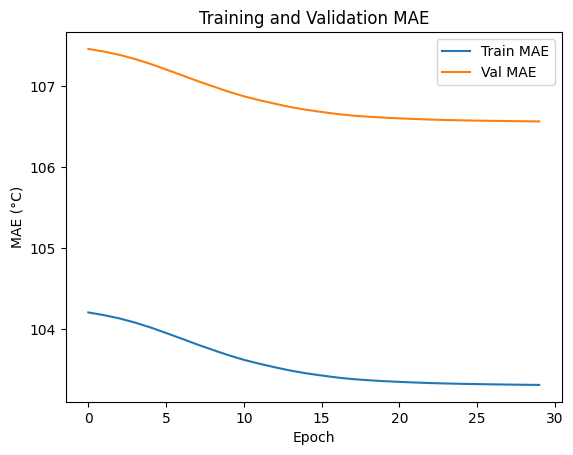

In [30]:
# 10) Train encoder, record MAE per epoch
epochs = 30
train_mae, val_mae = [], []
for ep in range(epochs):
    enc.train()
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        opt.zero_grad()
        emb = enc(Xb)
        loss = crit(emb.mean(dim=1), yb)
        loss.backward(); opt.step()
    # Evaluate
    enc.eval()
    with torch.no_grad():
        def eval_loader(dl):
            preds, trues = [], []
            for Xb, yb in dl:
                emb = enc(Xb.to(device)).cpu().numpy()
                preds.append(emb.mean(axis=1))
                trues.append(yb.numpy())
            p = np.concatenate(preds); t = np.concatenate(trues)
            return mean_absolute_error(t, p)
        train_mae.append(eval_loader(train_loader))
        val_mae.append(eval_loader(val_loader))

# Plot training curve
plt.figure()
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae,   label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (°C)')
plt.title('Training and Validation MAE')
plt.legend()
plt.savefig('training_curve.png')

In [32]:
# 11) Prepare embeddings & train LightGBM
# Modeli eval moduna alıp grad’i kapatıyoruz
enc.eval()
with torch.no_grad():
    # train embeddings
    emb_train = np.vstack([
        enc(Xb.to(device))
        .detach()        # graf bilgisini kopar
        .cpu()
        .numpy()
        for Xb, _ in train_loader
    ])
    # val embeddings
    emb_val = np.vstack([
        enc(Xb.to(device)).detach().cpu().numpy()
        for Xb, _ in val_loader
    ])

# LightGBM’e hazır hale getir
gbm_train = lgb.Dataset(
    np.vstack([emb_train, emb_val]),
    np.concatenate([y_train, y_val])
)

params = {'objective': 'regression', 'max_depth':10, 'learning_rate':0.05}
gbm = lgb.train(params, gbm_train, num_boost_round=150)

# Test set performansı
with torch.no_grad():
    emb_test = np.vstack([
        enc(Xb.to(device)).detach().cpu().numpy()
        for Xb, _ in test_loader
    ])
y_pred = gbm.predict(emb_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"Test MAE:  {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2:   {r2:.4f}")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3365
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 64
[LightGBM] [Info] Start training from score 104.849348
[LightGBM] [Warning] No further splits with positi

c:\Users\Ercan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\Users\Ercan\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.18228e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\Ercan\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.78302e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\Ercan\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.09308e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\Ercan\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:12

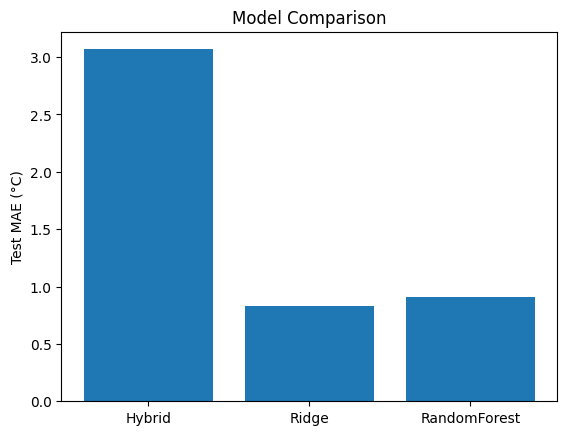

In [33]:
# 12) Baseline models
# Flatten sequence windows
Xf_train = X_train.reshape(len(X_train), -1)
Xf_test  = X_test.reshape(len(X_test),  -1)

# Ridge CV
ridge = GridSearchCV(Ridge(), {'alpha': [0,0.1,1.0]}, cv=5, scoring='neg_mean_absolute_error')
ridge.fit(Xf_train, y_train)
y_ridge = ridge.predict(Xf_test); mae_r = mean_absolute_error(y_test, y_ridge)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10)
rf.fit(Xf_train, y_train)
y_rf = rf.predict(Xf_test); mae_rf = mean_absolute_error(y_test, y_rf)

# Bar chart of MAEs
models = ['Hybrid','Ridge','RandomForest']
maes   = [mae, mae_r, mae_rf]
plt.figure()
plt.bar(models, maes)
plt.ylabel('Test MAE (°C)')
plt.title('Model Comparison')
plt.savefig('baseline_mae.png')

In [35]:
# 13) Present final metrics
metrics_df = pd.DataFrame({
    'Model': ['Hybrid','Ridge','RandomForest'],
    'Test MAE': [mae, mae_r, mae_rf],
    'Test RMSE': [rmse, np.nan, np.nan],
    'Test R2': [r2, np.nan, np.nan]
})

metrics_df

,Model,Test MAE,Test RMSE,Test R2
0,Hybrid,3.067049,4.29518,0.259427
1,Ridge,0.832317,NaN,NaN
2,RandomForest,0.907393,NaN,NaN
